### ASTR 3970 / 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 4
### Due: Saturday, Feb 15th at 11.59pm CST
---

## Problem 1

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw4_data_1.npy`. This is a (10 x 2) numpy array, with voltage measurements in the first column and heteroscedastic voltage uncertainties in the second column. Compute the sample mean and the standard error on the sample mean for this data.

2) Fit the appropriate ln-likelihood function and find the best-fit mean voltage.

3) Compute and plot the Bayesian posterior probability density (*not the log posterior*) for the mean voltage assuming a uniform prior for the mean in the range 3.5 to 6.5. Make sure this posterior pdf is normalized!

4) By either drawing samples from this posterior, or using your gridded posterior pdf to make a cdf, find the equal-tailed 68.3% credible region for the mean, and compare the upper and lower boundaries to $\mu+\sigma_\mathrm{mean}$ and $\mu-\sigma_\mathrm{mean}$. *Also* find the MAP value of the mean.

5) Repeat (3) and (4) this time with a prior on the mean that is uniform in the range 4.5 to 5.5. 

6) Now, imagine that we read an old paper about the experiment that gave us the voltage measurements, and they found that the mean was actually $6.1\pm0.25$. Repeat (3) and (4) this time with a Gaussian prior on the mean centered at $6.1$ with standard deviation of $0.25$.

7) Plot all of the normalized posterior pdfs for $\mu$ from (3), (5), and (6) on the same plot, making sure that the xlim of the plot spans 0 to 10.

8) You have made sure that the posterior pdfs are properly normalized, but until now you have ignored the meaning of that normalization constant. It is the Bayesian evidence for the particular model you have applied! Compute the evidence under a new model where the prior for the mean is a delta function at the best-fit value you found in (1) *(think about this and don't just immediately go looking for a `scipy.stats` delta function)*. Compare this to the evidence found under the prior in (3). Taking ratios to make a Bayes factor, which model is favored? Is there much of an Occam penalty by having the wide prior compared to knowing the mean exactly? 

### Solution

In [2]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import scipy.stats
import scipy.integrate
import time
import corner

In [3]:
#Part 1
data= np.load('../../../homeworks/hw_data/hw4_data_1.npy')

#Organize data
meas=data[:, 0] #Voltage Measurements
uncert= data[:, 1] #Voltage Uncertainties (Heteroscedastic)

#Calculate Mean and Standard Error
mean1= np.sum(meas/(uncert**2))/np.sum(1/uncert**2)
error1= np.sum(1/uncert**2)**(-1/2)
print("Mean:", mean1)
print("Standard Error:", error1)

Mean: 4.942118214425304
Standard Error: 0.43024334605205083


In [5]:
#Part 2 Log-Likelihood
def inverse_log_likelihood(mu, x, x_uncert):
    constant= -1/2 * np.log(2*np.pi*uncert**2)
    return -np.sum( constant - ((x-mu)**2)/(2*(x_uncert)**2)) #use inverse (multiply by -1) because we are using optimize to minimize even though we want to maximize

def find_mean(beta, meas, uncert):
    f_squared = lambda beta: inverse_log_likelihood(beta, meas, uncert) 
    beta_squared = optimize.fmin(f_squared, beta, disp=False)
    return beta_squared

beta=3 #intial guess for mu
mean= find_mean(beta, meas, uncert)
print("Best fit mean:", mean[0])

Best fit mean: 4.942089843750004


SRT: Good!

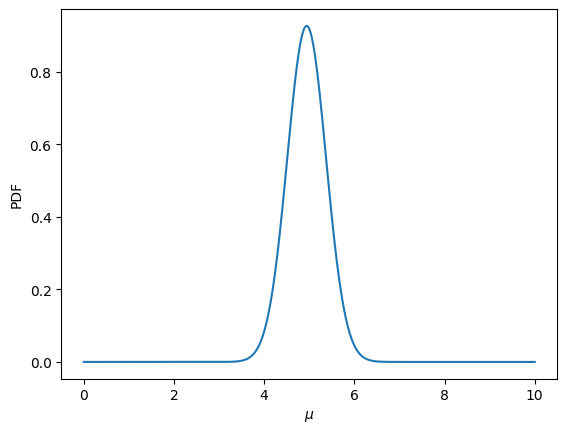

In [6]:
#Part 3
mu_arr = np.linspace(0, 10, 1000)
posterior_arr=[]
for mu in mu_arr:
    logL= -1*inverse_log_likelihood(mu, meas, uncert)
    L = np.exp(logL) 
    prior = 1 / (6.5 - 3.5) #constant within range
    posterior = L * prior #Warning: This is unnormalized

    posterior_arr.append(posterior)
area1=(np.sum(posterior_arr)*(mu_arr[1]-mu_arr[0]))
posterior_arr= posterior_arr/(np.sum(posterior_arr)*(mu_arr[1]-mu_arr[0])) #Normalizing posterior PDF


plt.plot(mu_arr, posterior_arr)
plt.xlabel(r"$\mu$")
plt.ylabel("PDF")
plt.show()


68.3% Confidence Interval: [4.514514514514515, 5.375375375375375]
Compare: [4.511874868373253, 5.372361560477355]
MAP= 4.944944944944945


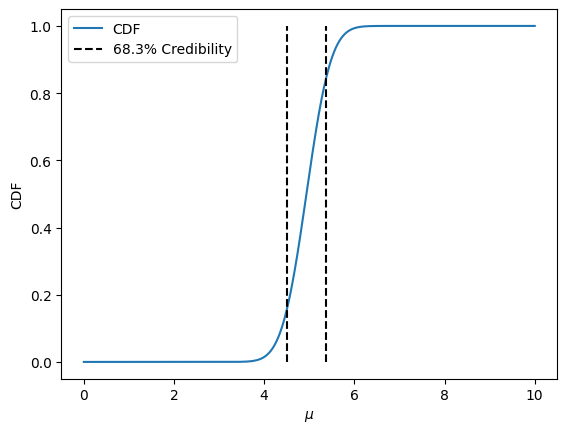

In [7]:
#Part 4
cdf= np.cumsum(posterior_arr) #Warning: This is unnormalized
cdf= cdf/cdf[-1] #Divide by the last 
plt.plot(mu_arr, cdf, label="CDF")
plt.xlabel(r"$\mu$")
plt.ylabel("CDF")

#68.3 confidence
lower_bound = mu_arr[np.searchsorted(cdf, 0.1585)]
upper_bound = mu_arr[np.searchsorted(cdf, 0.8415)]
print(f"68.3% Confidence Interval: [{lower_bound}, {upper_bound}]")

plt.vlines(lower_bound,0,1, color='k', linestyle='dashed', label="68.3% Credibility")
plt.vlines(upper_bound, 0, 1, color='k', linestyle='dashed')

#Compare
mu_mean = np.sum(mu_arr * posterior_arr) * (mu_arr[1] - mu_arr[0]) #Mean
sigma_mean = np.sqrt(np.sum((mu_arr - mu_mean)**2 * posterior_arr) * (mu_arr[1] - mu_arr[0]))  # Std dev
print(f"Compare: [{mu_mean - sigma_mean}, {mu_mean + sigma_mean}]")

posterior_arr1= posterior_arr
#MAP
max_index=np.argmax(posterior_arr)
map = mu_arr[max_index]
print("MAP=", map)
plt.legend()
plt.show()
#

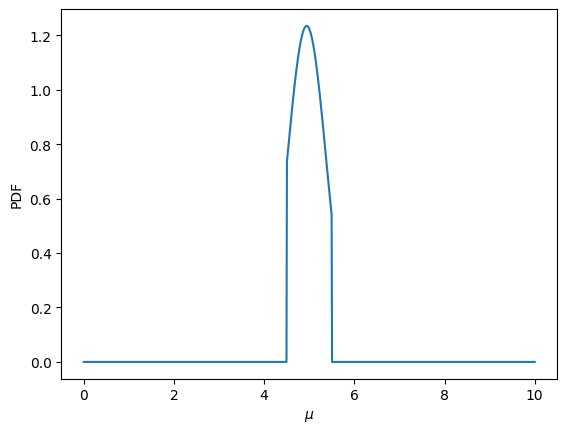

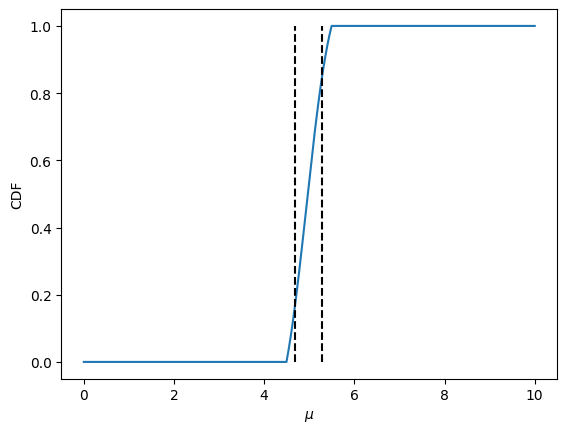

68.3% Confidence Interval: [4.674674674674675, 5.275275275275275]
Compare: [4.511874868373253, 5.372361560477355]
MAP= 4.944944944944945


In [8]:
#Part 5
mu_arr = np.linspace(0, 10, 1000)
posterior_arr=[]
for mu in mu_arr:
    logL= -1*inverse_log_likelihood(mu, meas, uncert)
    L = np.exp(logL) 
    if 4.5 < mu < 5.5:
        prior = 1  #constant within range
    else:
        prior=0
    posterior = L * prior #Warning: This is unnormalized

    posterior_arr.append(posterior)

posterior_arr= posterior_arr/(np.sum(posterior_arr)*(mu_arr[1]-mu_arr[0])) #Normalizing posterior PDF

plt.plot(mu_arr, posterior_arr)
plt.xlabel(r"$\mu$")
plt.ylabel("PDF")
plt.show()

#CDF
cdf= np.cumsum(posterior_arr) #Warning: This is unnormalized
cdf= cdf/cdf[-1] #Divide by the last 
plt.plot(mu_arr, cdf)
plt.xlabel(r"$\mu$")
plt.ylabel("CDF")


#68.3 confidence
lower_bound = mu_arr[np.searchsorted(cdf, 0.1585)]
upper_bound = mu_arr[np.searchsorted(cdf, 0.8415)]

plt.vlines(lower_bound,0,1, color='k', linestyle='dashed', label="68.3% Credibility")
plt.vlines(upper_bound, 0, 1, color='k', linestyle='dashed')
plt.show()

print(f"68.3% Confidence Interval: [{lower_bound}, {upper_bound}]")
#Compare
print(f"Compare: [{mean1-error1}, {mean1 + error1}]")

posterior_arr2 = posterior_arr
#MAP
max_index=np.argmax(posterior_arr)
map = mu_arr[max_index]
print("MAP=", map)

SRT: Excellent

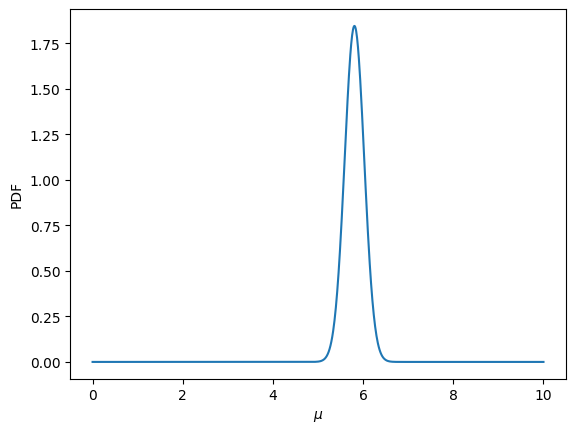

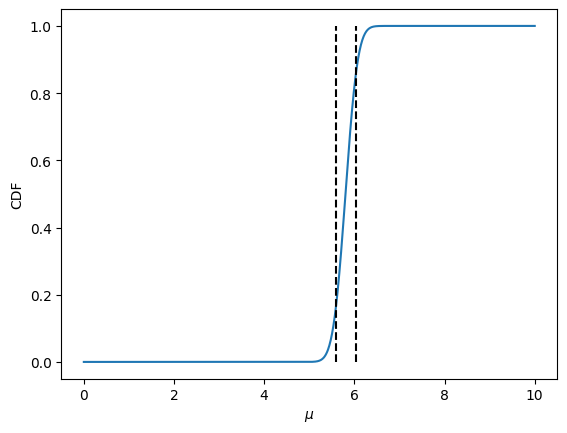

68.3% Confidence Interval: [5.595595595595595, 6.026026026026026]
Compare: [5.591577046151821, 6.023892398359287]
MAP= 5.8058058058058055


In [9]:
#Part 6
mu_arr = np.linspace(0, 10, 1000)
posterior_arr=[]
for mu in mu_arr:
    logL= -1*inverse_log_likelihood(mu, meas, uncert)
    L = np.exp(logL) 
    prior=scipy.stats.norm(loc=6.1, scale=0.25).pdf(mu)
    posterior = L * prior #Warning: This is unnormalized

    posterior_arr.append(posterior)
area3=(np.sum(posterior_arr)*(mu_arr[1]-mu_arr[0])) 
posterior_arr= posterior_arr/area3 #Normalizing posterior PDF




plt.plot(mu_arr, posterior_arr)
plt.xlabel(r"$\mu$")
plt.ylabel("PDF")
plt.show()

#CDF
cdf= np.cumsum(posterior_arr) #Unnormalized
cdf= cdf/cdf[-1] #Divide by the last 
plt.plot(mu_arr, cdf)
plt.xlabel(r"$\mu$")
plt.ylabel("CDF")


#68.3 confidence
lower_bound = mu_arr[np.searchsorted(cdf, 0.1585)]
upper_bound = mu_arr[np.searchsorted(cdf, 0.8415)]
plt.vlines(lower_bound,0,1, color='k', linestyle='dashed', label="68.3% Credibility")
plt.vlines(upper_bound, 0, 1, color='k', linestyle='dashed')
plt.show()
print(f"68.3% Confidence Interval: [{lower_bound}, {upper_bound}]")
#Compare
mu_mean = np.sum(mu_arr * posterior_arr) * (mu_arr[1] - mu_arr[0]) #Mean
sigma_mean = np.sqrt(np.sum((mu_arr - mu_mean)**2 * posterior_arr) * (mu_arr[1] - mu_arr[0]))  # Std dev
print(f"Compare: [{mu_mean - sigma_mean}, {mu_mean + sigma_mean}]")

posterior_arr3= posterior_arr
#MAP
max_index=np.argmax(posterior_arr)
map = mu_arr[max_index]
print("MAP=", map)

Text(0, 0.5, 'Posterior Probability')

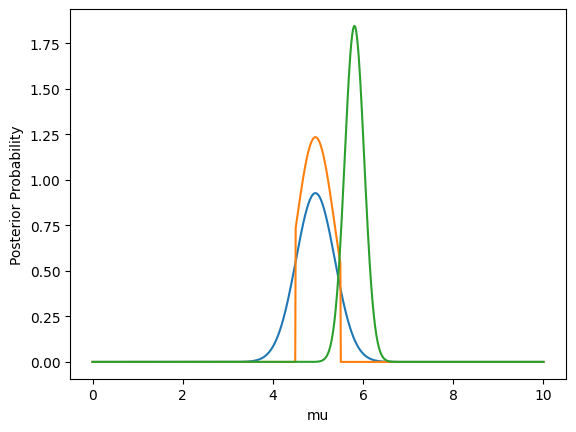

In [10]:
#Part 7
plt.plot(mu_arr, posterior_arr1)
plt.plot(mu_arr, posterior_arr2)
plt.plot(mu_arr, posterior_arr3)
plt.xlabel("mu")
plt.ylabel("Posterior Probability")

SRT: Nice!

Evidence (3): 3.855844173910163e-08
Evidence (8): 1.0723114197950375e-07
Bayes Factor: 0.3595824965332527
Model from part (8) is favored


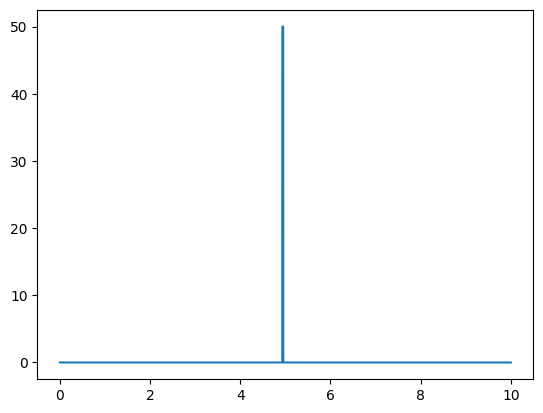

In [11]:
#Part 8
mu_arr = np.linspace(0, 10, 100000)
posterior_arr=[]
for mu in mu_arr: #Loop through linspace of mu (averages)
    logL= -1*inverse_log_likelihood(mu, meas, uncert)
    L = np.exp(logL) 
    if  (np.abs(mu-mean1) < 0.01):
        prior=1
        L_max= L
    else:
        prior=0
    posterior = L * prior #Unnormalized
    posterior_arr.append(posterior)
area4=(np.sum(posterior_arr)*(mu_arr[1]-mu_arr[0])) 
posterior_arr= posterior_arr/area4 #Normalizing posterior PDF
plt.plot(mu_arr, posterior_arr)
b_factor= area1/L_max
print("Evidence (3):", area1)
print("Evidence (8):", L_max)
print("Bayes Factor:", b_factor)
if b_factor > 1:
    print("Model from part (3) is favored")
else:
    print("Model from part (8) is favored")


SRT: You got it! I am going to deduct one point though since you used an unnecessary approximation to a delta function. It really is just the value of the likelihood at the mean value since a delta function integrated against another function is just the function value itself. -1 point

#### Is there much of an Occam penalty by having the wide prior compared to knowing the mean exactly? 
There is a considerable Occam penalty for a wider prior than knowning the exact mean since the Bayes factor of the evidence for the uniform distibution over the evidence for the delta function distirbution is ~0.35. The Occam penalty on the uniform distibution punishes having a range of priors to test rather than one prior.

## Problem 2

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw4_data_2.npy`, which is a (3 x 20) numpy array that you used in `Lecture_9`. Set `x, y, sigma_y = data`. 

We're going to do some polynomial fits to this data just like in `Lecture 9`. However, in all cases you should **keep the $y$-intercept fixed at $-0.23$**. 

2) Use the following code to compute the un-normalized posterior pdf (i.e. just the likelihood x prior) on a grid of the linear coefficient (i.e. the slope) of a linear model, with a uniform prior between 0.5 and 1.5. Plot this posterior pdf. Remember this is just a one-dimensional model because the $y$-intercept is fixed. I advise a grid size of 100.

In [12]:
#Functions to do a polynomial fit, and compute the likelihood
def polynomial_fit(theta, x):
    """Polynomial model of degree (len(theta) - 1)"""
    # For a polynomial with order 1, this gives theta_0 + theta_1*x
    # For a polynomial with order 2, this gives theta_0 + theta_1*x + theta_2*x^2, etc.
    return sum(t * x ** n for (n, t) in enumerate(theta))

# compute the data log-likelihood given a model
def logL(theta, data, model=polynomial_fit):
    """Gaussian log-likelihood of the model at theta"""
    x, y, sigma_y = data
    y_fit = model(theta, x)
    return sum(scipy.stats.norm.logpdf(*args) 
               for args in zip(y, y_fit, sigma_y))

3) Using your 1D gridded likelihood-x-prior, compute the Bayesian evidence of this linear model. This may be a big number!

4) Now compute the joint 2D posterior pdf (again just the likelihood x prior) of linear and quadratic coefficients of a quadratic model. Give the linear coefficient a uniform prior between 0.5 and 1.5. Give the quadratic coefficient a uniform prior between -1 and 0.25. Plot this two-dimensional posterior. Remember this is a two-dimensional model because the $y$-intercept is fixed. I advise a grid size of 100 in each model dimension.

5) Using your 2D gridded likelihood-x-prior, compute the Bayesian evidence of the quadratic model. 

6) Calculate the Bayes factor for a linear versus quadratic model. How does this compare/contrast with the BIC model comparison in Lecture 9? 

### Solution

In [13]:
#Part 1
data2= np.load('../../../homeworks/hw_data/hw4_data_2.npy')
x, y, sigma_y = np.load('../../../homeworks/hw_data/hw4_data_2.npy')

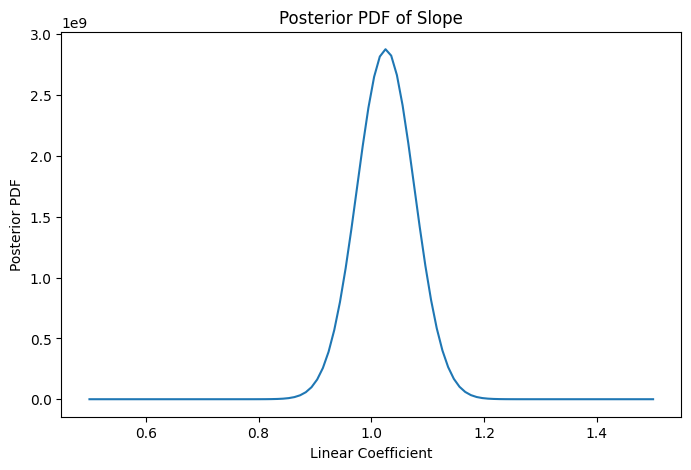

In [19]:
#Part 2
# Define prior limits
slope_values = np.linspace(0.5, 1.5, 100)

# Compute un-normalized posterior (likelihood * prior)
ppdf=[]
likelihood1= []
for slope in slope_values:
    if 0.5 < slope <1.5:
        prior=1/(1.5-0.5)
    else:
        prior=0 
    likelihood= np.exp(logL([-0.23, slope], data2))
    likelihood1.append(likelihood)
    ppdf.append(np.array([likelihood*prior]))


#Plotting
plt.figure(figsize=(8, 5))
plt.plot(slope_values, ppdf)
plt.xlabel('Linear Coefficient')
plt.ylabel('Posterior PDF')
plt.title('Posterior PDF of Slope')
plt.show()

In [15]:
#Part 3
evidence= np.sum(ppdf) * (slope_values[1]-slope_values[0])
print("Evidence=", evidence)

Evidence= 365684733.1606578


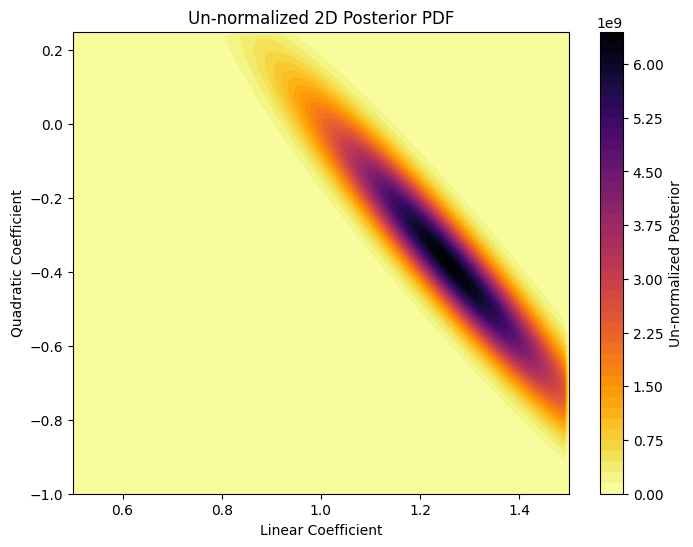

In [16]:
#Part 4
theta1_arr= np.linspace(0.5, 1.5, 100)
theta2_arr= np.linspace(-1, 0.25, 100)

# Compute un-normalized posterior (likelihood * prior)
posterior_2d = np.zeros((100, 100))
likelihood2= []
for i, theta1 in enumerate(theta1_arr): #Loops though linear
    for j, theta2 in enumerate(theta2_arr): #Loops through quad
        if (0.5 < theta1 < 1.5) & (-1 < theta2< 0.25):
            prior= 1/(0.25-(-1))
        else:
            prior=0
        likelihood = np.exp(logL([-0.23, theta1, theta2], data2))
        posterior_2d[i, j] = likelihood * prior
        likelihood2.append(likelihood)
posterior_2d= posterior_2d.T #Transpose since I looped through slope first

# Plot the 2D posterior
plt.figure(figsize=(8, 6))
plt.contourf(theta1_arr, theta2_arr, posterior_2d, levels=50, cmap='inferno_r')
plt.colorbar(label='Un-normalized Posterior')
plt.xlabel('Linear Coefficient')
plt.ylabel('Quadratic Coefficient')
plt.title('Un-normalized 2D Posterior PDF')
plt.show()

In [17]:
#Part 5
delta1= theta1_arr[1] - theta1_arr[0] #wannabe infinitesimal for the linear coeff. linspace
delta2= theta2_arr[1] - theta2_arr[0] #wannabe infinitesimal for the quadratic coeff. linspace

evidence2= np.sum(posterior_2d) * (delta1) *(delta2)
print("Evidence=", evidence2)

Evidence= 487806846.23314697


In [18]:
#Part 6
bayes_factor= evidence2/evidence
print(f"With a Bayes factor of {bayes_factor}, the quadratic model is more favored than the linear model")

N1= len(data2[0])
k1= 1
L1= np.log(np.max(likelihood1))
bic1= -2*L1 + k1*np.log(N1)

N2= len(data2[0])
k2= 2 
L2= np.log(np.max(likelihood2))
bic2= -2*L2 + k2*np.log(N2)


print(f"BIC of linear model: {bic1} is more favored than the BIC of the quadratic model: {bic2}")

With a Bayes factor of 1.3339546390601893, the quadratic model is more favored than the linear model
BIC of linear model: -40.56497783764137 is more favored than the BIC of the quadratic model: -39.60826138257528


#### How does this compare/contrast with the BIC model comparison in Lecture 9? 
The Bayes factor and the BIC contrast! The Bayes factor favors the qudratic model, while the BIC favores the linear model. The Bayes factor is a more robust indicator than BIC but they do not differ by that much.

SRT: Well done!

49/50